<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Reddit NPL Classfication Challenge
Notebook 3: Modeling

This notebook contains all the modeling for this project. Excluding the baseline model, I ran 7 models in total pipelined with either CountVectorizer or TfidfVectorizer and used GridSearch to find the optimal parameters. For each model, I would explain the reason why I chose to use them, and the rationale behind how I optimize them.

- [Baseline Model](#Baseline-Model)
- [Model 1 - Logistic Regression with CountVectorizer](#Model-1---Logistic-Regression-with-CountVectorizer)
- [Model 2 - Logistic Regression with TfidfVectorizer](#Model-2---Logtistic-Regression-with-TfidfVectorizer)
- [Model 3 - K-Nearest Neighbors with TfidfVectorizer](#Model-3---K-Nearest-Neighbors-with-TfidfVectorizer)
- [Model 4 - Naive Bayes with CountVectorizer](#Model-4---Naive-Bayes-with-CountVectorizer)
- [Model 5 - Naive Bayes with TfidfVectorizer](#Model-5---Naive-Bayes-with-TfidfVectorizer)
- [Model 6 - Random Forest with TfidfVectorizer](#Model-6---Random-Forest-with-TfidfVectorizer)
- [Model 7 - Extra Trees with TfidfVectorizer](#Model-7---Extra-Trees-with-TfidfVectorizer)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [3]:
df = pd.read_csv('../data/combined_for_npl.csv')

In [4]:
df.head()

,subreddit,text
0,Jokes,A woman visited a doctor „Kiss me!“ She said.\...
1,Jokes,Spider-man must be high all the time... Since ...
2,Jokes,An old man walks into the barbershop for a sha...
3,Jokes,I remember being a kid and my parents filling ...
4,Jokes,"Jesus can walk on water, babies are 72% water,..."


In [5]:
df.subreddit = df.subreddit.map({'Jokes': 1,
                                'TalesFromRetail': 0})

### Baseline Model

My first step is to establish a baseline model.

In [7]:
X = df['text']
y = df['subreddit']

In [8]:
y.value_counts(normalize = True)

1    0.502401
0    0.497599
Name: subreddit, dtype: float64

As indicated above, my base model has a 50.24% accuracy, which means my model will need to at least beat this number.

### Modeling Preparation

Pursuant to the preprocessing of notebook 2, I will be using the custom stop words in my modeling. 

In [9]:
stop = []
for word in ENGLISH_STOP_WORDS:
    if word != 'i':
        stop.append(word)
        
stop_words = set(stop).union('b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 
                              'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 
                              'y', 'z', '_')

I also created a function to plot confusion matrix and other classification metrics so that I can easily check the performance of the model after each run.

In [10]:
def get_matrix(X_test, y_test, model):
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    sensitivity = tp/ (tp + fn)
    specificity = tn/ (tn + fp)
    precision = tp/ (tp + fp)
    print(f'Sensitivity: {sensitivity}')
    print(f'Specificity: {specificity}')
    print(f'Precision: {precision}')
    return plot_confusion_matrix(model, X_test, y_test, values_format = 'd');

In [11]:
# set variable and target for modeling
X = df['text']
y = df['subreddit']

# train test split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

### Model 1 - Logistic Regression with CountVectorizer

My first model is to use logistic regression with count vectoirzer. Although simple, logistic regression is a fast, and effective model for classification. Plus it returns coefficients that are intepretable and intuitive.

In [10]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_words, 
                             token_pattern = u"(?u)\\b\\w+\\b")),
    ('logreg', LogisticRegression())
])


pipe_params = {'cvec__max_features': [10000, 15000, 20000],
              'cvec__min_df': [2,3],
              'cvec__max_df': [.90, .95],
              'cvec__ngram_range':[(1,1), (1,2)]}

gs = GridSearchCV(pipe, 
                  pipe_params,
                  cv = 5, 
                  verbose = 1,
                  n_jobs = -1) 

gs.fit(X_train, y_train)

print(f'best params: {gs.best_params_}')
print(f'best cv score: {gs.best_score_}')
print(f'train score: {gs.score(X_train, y_train)}')
print(f'test score: {gs.score(X_test, y_test)}')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 11.9min finished


best params: {'cvec__max_df': 0.9, 'cvec__max_features': 10000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2)}
best cv score: 0.9863513802187824
train score: 0.9991557619248628
test score: 0.9898712808609411


Sensitivity: 0.9916001679966401
Specificity: 0.9881255301102629
Precision: 0.9882796149016325


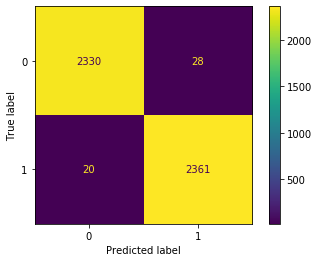

In [11]:
get_matrix(X_test, y_test, gs)

The model has a 98.99% accuracy, which is to my surprise -- I didn't expect logtistic regression could perform so well! However my best parameter takes in 10,000 features, which is a lot considering how much vocabulary each English speaker has. Therefore I would like to fine tune my model to make it fewer features and see if I can still keep the high accuracy level.

#### Fine tuning the features

This time I'm trying out 4000, 6000, and 8000 features.

In [12]:
pipe_1 = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_words, 
                             token_pattern = u"(?u)\\b\\w+\\b")),
    ('logreg', LogisticRegression())
])


pipe_params_1 = {'cvec__max_features': [4000, 6000, 8000],
              'cvec__min_df': [2,3],
              'cvec__max_df': [.90, .95],
              'cvec__ngram_range':[(1,1), (1,2)]}

gs_1 = GridSearchCV(pipe_1, 
                  pipe_params_1,
                  cv = 5, 
                  verbose = 1,
                  n_jobs = -1) 

gs_1.fit(X_train, y_train)

print(f'best params: {gs_1.best_params_}')
print(f'best cv score: {gs_1.best_score_}')
print(f'train score: {gs_1.score(X_train, y_train)}')
print(f'test score: {gs_1.score(X_test, y_test)}')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 13.7min finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


best params: {'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2)}
best cv score: 0.9864921261723364
train score: 0.9988039960602223
test score: 0.9900822958430049


Sensitivity: 0.991180176396472
Specificity: 0.9889737065309584
Precision: 0.989103101424979


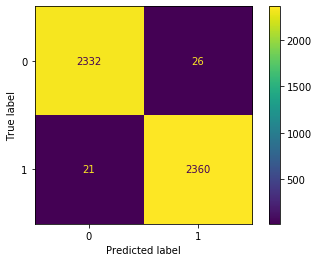

In [13]:
get_matrix(X_test, y_test, gs_1)

The model got even better, with an almost 99% rate all the metrics! What's more, the best model only needs 4,000 features, but I would still like to see if I can do better.

### Model 2 - Logtistic Regression with TfidfVectorizer

So I decdied to do the logistic regression with TfidfVectorizer to see if any improvements can be achieved. TfidVectorizer focuses on the unique words in each class vs similar words. For my project, the two subreddits being examined both took major form of story, I believe many frequent words might overlap. However, according to the EDA, they are still identifiable unique words specific to each subreddits. Therefore I believe using TfidfVectorizer could help and many reduce the features needed for a good model even more.

In [14]:
pipe_2 = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = stop_words , 
                             token_pattern = u"(?u)\\b\\w+\\b")),
    ('logreg', LogisticRegression())
])


pipe_params_2 = {'tvec__max_features': [2000, 3000, 4000],
              'tvec__min_df': [2,3],
              'tvec__max_df': [.90, .95],
              'tvec__ngram_range':[(1,1), (1,2)]}

gs_2 = GridSearchCV(pipe_2, 
                  pipe_params_2,
                  cv = 5, 
                  verbose = 1,
                  n_jobs = -1) 

gs_2.fit(X_train, y_train)

print(f'best params: {gs_2.best_params_}')
print(f'best cv score: {gs_2.best_score_}')
print(f'train score: {gs_2.score(X_train, y_train)}')
print(f'test score: {gs_2.score(X_test, y_test)}')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 16.0min finished


best params: {'tvec__max_df': 0.9, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}
best cv score: 0.982341333442907
train score: 0.9874771352187983
test score: 0.984595906309348


Sensitivity: 0.9857202855942881
Specificity: 0.9834605597964376
Precision: 0.9836546521374686


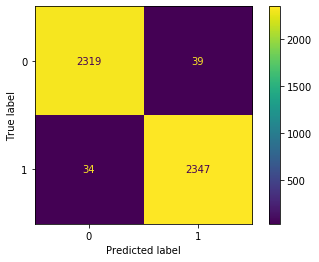

In [15]:
get_matrix(X_test, y_test, gs_2)

It didn't disappoint me. With 2000 features, I can get a 98.5% accuracy rate, only 0.49% lower than the 10,000-feature model and 0.5% lower than the 4,000-feature model. I believe this is the best model so far. (And spoiler alert, this is the best model among all!)

### Model 3 - K-Nearest Neighbors with TfidfVectorizer

With the above insipiring result, I decided to test out all models beyond using 4000 features at most. Next I examined KNN as it's also a very common classifier. However compared to Logistic Regression, KNN is not able to provide feature significance for my reference. With that in mind, I'm still curious to see how the result will turn out. I decided only to use KNN with TfidfVectorizer because KNN tends to overfit a lot and TfidfVectorizer may help with this issue with fewer features. Also since all the features are on the same scale, no standardization is needed for this modeling.

In [12]:
pipe_knn = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = stop_words, 
                             token_pattern = u"(?u)\\b\\w+\\b")),
    ('knn', KNeighborsClassifier())
])


pipe_params_knn = {'tvec__max_features': [2000, 4000],
              'tvec__min_df': [3],
              'tvec__max_df': [.90],
              'tvec__ngram_range':[(1,1), (1,2)],
              'knn__n_neighbors': [1, 59, 99]}

gs_knn = GridSearchCV(pipe_knn, 
                  pipe_params_knn,
                  cv = 5, 
                  verbose = 1,
                  n_jobs = -1) 

gs_knn.fit(X_train, y_train)

print(f'best params: {gs_knn.best_params_}')
print(f'best cv score: {gs_knn.best_score_}')
print(f'train score: {gs_knn.score(X_train, y_train)}')
print(f'test score: {gs_knn.score(X_test, y_test)}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.2min finished


best params: {'knn__n_neighbors': 99, 'tvec__max_df': 0.9, 'tvec__max_features': 4000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 1)}
best cv score: 0.9320386405317157
train score: 0.9295764738989728
test score: 0.9364844903988183


Sensitivity: 0.9638807223855523
Specificity: 0.9088210347752332
Precision: 0.9143426294820717


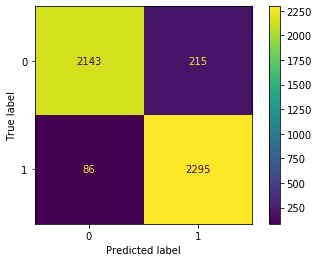

In [20]:
get_matrix(X_test, y_test, gs_knn)

With an accuracy of 93.6%, I wouldn't say KNN perform badly but it's certainly not as good as the logistic regression in this case. The KNN model especially suffers from the specificity compared to logistic regression, which means it tends to classify tales from retail as jokes. 

### Model 4 - Naive Bayes with CountVectorizer

Next I would like to model with Naive Bayes. Naive Bayes is a prime model for classification problems where feature sets are very large (credit in [link](https://medium.com/@dannymvarghese/comparative-study-on-classic-machine-learning-algorithms-part-2-5ab58b683ec0)). As I'm modeling feature counts, which are all positive integers, I will use multinomial naive bayes. I will also start with using CountVectorizer with multiple feature options. 

In [24]:
pipe_cm = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_words, 
                             token_pattern = u"(?u)\\b\\w+\\b")),
    ('nb', MultinomialNB())
])


pipe_params_cm = {'cvec__max_features': [2000, 3000, 4000],
              'cvec__min_df': [2,3],
              'cvec__max_df': [.90, .95],
              'cvec__ngram_range':[(1,1), (1,2)]}

gs_cm = GridSearchCV(pipe_cm, 
                  pipe_params_cm,
                  cv = 5, 
                  verbose = 1,
                  n_jobs = -1) 

gs_cm.fit(X_train, y_train)

print(f'best params: {gs_cm.best_params_}')
print(f'best cv score: {gs_cm.best_score_}')
print(f'train score: {gs_cm.score(X_train, y_train)}')
print(f'test score: {gs_cm.score(X_test, y_test)}')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 15.7min finished


best params: {'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2)}
best cv score: 0.9298572515231183
train score: 0.9407626283945406
test score: 0.9248786663853134


Sensitivity: 0.8559428811423772
Specificity: 0.9944868532654793
Precision: 0.9936616284739151


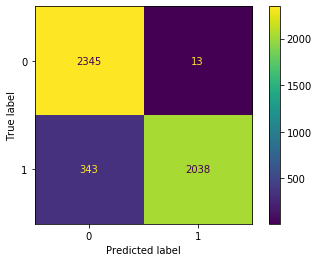

In [25]:
get_matrix(X_test, y_test, gs_cm)

The accuracy of Naive Bayes with CountVectorizer is 92.5%, lowest of all models and especially suffers from sensitivity, which means it tends to classify jokes posts as tales from retail posts. However, it has almost perfect specificity and precision score. This means this model is better at classifying tales from retail posts.

### Model 5 - Naive Bayes with TfidfVectorizer

Due to my computer's capacity, I did not have luxury to test out too many parameter combos in my grid search. My strategy is to use a vectorizer to help narrow down the parameters and test on the other vectorizer to compare the results. As naive bayes with CountVectorizer didn't give me a great model, I decided to use its best parameters to test on TfidfVectorizer.

In [26]:
pipe_tm = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = stop_words, 
                             token_pattern = u"(?u)\\b\\w+\\b")),
    ('nb', MultinomialNB())
])


pipe_params_tm = {'tvec__max_features': [4000],
              'tvec__min_df': [2,3],
              'tvec__max_df': [.90, .95],
              'tvec__ngram_range':[(1,1), (1,2)]}

gs_tm = GridSearchCV(pipe_tm, 
                  pipe_params_tm,
                  cv = 5, 
                  verbose = 1,
                  n_jobs = -1) 

gs_tm.fit(X_train, y_train)

print(f'best params: {gs_tm.best_params_}')
print(f'best cv score: {gs_tm.best_score_}')
print(f'train score: {gs_tm.score(X_train, y_train)}')
print(f'test score: {gs_tm.score(X_test, y_test)}')

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.0min finished


best params: {'tvec__max_df': 0.9, 'tvec__max_features': 4000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2)}
best cv score: 0.9330234661574796
train score: 0.948853243281272
test score: 0.9301540409369066


Sensitivity: 0.8685426291474171
Specificity: 0.9923664122137404
Precision: 0.9913710450623202


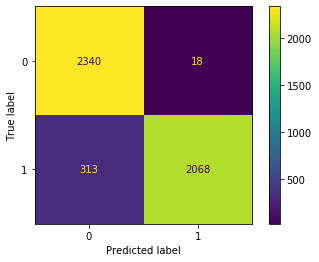

In [27]:
get_matrix(X_test, y_test, gs_tm)

With TfidfVectorizer, the accuracy improved a little to 93%, close to KNN's score but still far from what logistic regression was able to achieve. Similar to the CountVectorizer, it also suffers low sensitivity. 

### Model 6 - Random Forest with TfidfVectorizer

So far using TfidfVectorizer has proved to have better performance on my datasets, therefore in the following model I decided to only vectorize the data with TfidfVectorizer, not CountVectorizer. Random Forest handles overfitting efficiently compared to regular decision trees.

In [28]:
pipe_rf = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = stop_words, 
                             token_pattern = u"(?u)\\b\\w+\\b")),
    ('rf', RandomForestClassifier())
])


pipe_params_rf = {'tvec__max_features': [2000, 4000],
              'tvec__min_df': [3],
              'tvec__max_df': [.90],
              'tvec__ngram_range':[(1,2)],
              'rf__n_estimators': [75, 100, 125],
              'rf__max_depth': [None, 5, 10],
              'rf__max_features': ['auto', 60, 80, 100]}

gs_rf = GridSearchCV(pipe_rf, 
                  pipe_params_rf,
                  cv = 5,
                  verbose = 1,
                  n_jobs = -1) 

gs_rf.fit(X_train, y_train)

print(f'best params: {gs_rf.best_params_}')
print(f'best cv score: {gs_rf.best_score_}')
print(f'train score: {gs_rf.score(X_train, y_train)}')
print(f'test score: {gs_rf.score(X_test, y_test)}')

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 47.7min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 80.4min finished


best params: {'rf__max_depth': None, 'rf__max_features': 100, 'rf__n_estimators': 100, 'tvec__max_df': 0.9, 'tvec__max_features': 2000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2)}
best cv score: 0.9842409335075619
train score: 1.0
test score: 0.9829077864528382


Sensitivity: 0.9756404871902562
Specificity: 0.9902459711620017
Precision: 0.9901960784313726


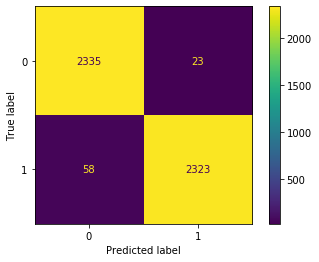

In [29]:
get_matrix(X_test, y_test, gs_rf)

Random Tree gave me a fairly good accuracy score of 98.3%. However notably, the train score is 100%, which indicates a slight level of overfitting, which is common due to the nature of random trees. Overall it's a good model, with also 2000 features needed to achieve such result. However due to the high computational cost of random tree models, in my case, 80.4 minutes to fit 360 models vs 13.7 minutes to fit 120 models for Model 2, I would prefer to choose the logistic regression (plus the result is slightly better too).

### Model 7 - Extra Trees with TfidfVectorizer

Finally I wanted to use the Extra Tree. Extra Trees is very similar to random forest only that random forest uses bootstrap replicas while extra trees uses the whole original sample. In addition extra trees selects split nodes randomly vs random forest selects the optimal point. These two differences indicate that extra trees is likely to have more variance yet faster to run than random forest.

In [30]:
pipe_et = Pipeline([
    ('tvec', TfidfVectorizer(token_pattern = u"(?u)\\b\\w+\\b")),
    ('et', ExtraTreesClassifier())
])


pipe_params_et = {'tvec__max_features': [2000],
              'tvec__min_df': [3],
              'tvec__max_df': [.90],
              'tvec__ngram_range':[(1,2)],
              'et__n_estimators': [125, 150],
              'et__max_depth': [None],
              'et__max_features': [100]}

gs_et = GridSearchCV(pipe_et, 
                  pipe_params_et,
                  cv = 5,
                  verbose = 1,
                  n_jobs = -1) 

gs_et.fit(X_train, y_train)

print(f'best params: {gs_et.best_params_}')
print(f'best cv score: {gs_et.best_score_}')
print(f'train score: {gs_et.score(X_train, y_train)}')
print(f'test score: {gs_et.score(X_test, y_test)}')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  7.2min finished


best params: {'et__max_depth': None, 'et__max_features': 100, 'et__n_estimators': 150, 'tvec__max_df': 0.9, 'tvec__max_features': 2000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2)}
best cv score: 0.977909098312509
train score: 1.0
test score: 0.9778434268833087


Sensitivity: 0.9655606887862243
Specificity: 0.9902459711620017
Precision: 0.9900947459086994


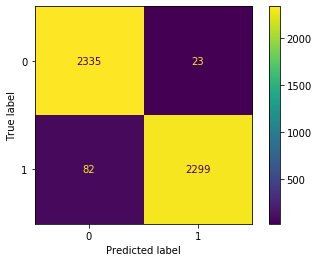

In [31]:
get_matrix(X_test, y_test, gs_et)

Not to my surprise, the result for extra trees is slightly lower than random forest, at 97.8%, with more overfitting indicated by the 100% training score. However it took longer for this model to run. My guess is the model was run while other programs were in the use too, which slowed down the process.

### Save to Pickle

In [43]:
import pickle 

file_name = '../assets/logreg.pkl'
pickle.dump(gs, open(file_name, 'wb'))

file_name = '../assets/logreg_1.pkl'
pickle.dump(gs_1, open(file_name, 'wb'))

file_name = '../assets/logreg_2.pkl'
pickle.dump(gs_2, open(file_name, 'wb'))

file_name = '../assets/knn.pkl'
pickle.dump(gs_knn, open(file_name, 'wb'))

file_name = '../assets/tvecmulti.pkl'
pickle.dump(gs_tm, open(file_name, 'wb'))

file_name = '../assets/cvecmulti.pkl'
pickle.dump(gs_cm, open(file_name, 'wb'))

file_name = '../assets/ranforest_tm.pkl'
pickle.dump(gs_rf, open(file_name, 'wb'))

file_name = '../assets/ranforest_tm.pkl'
pickle.dump(gs_et, open(file_name, 'wb'))